## Step 0: Preparation

In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [3]:
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

In [4]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cu121


#### Load dataset and preprocessing

In [5]:
# Khi chạy bằng colab
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# train_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD001.txt"
train_3 = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD003.txt"
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_3 = pd.read_csv(train_3, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''

In [7]:
# remaining_rul = max_rul - cycle
max_cycle = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_3.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [9]:
# Normalization
df = train_3.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.470930,0.769231,0.0,0.0,0.355972,0.370523,0.308580,0.0,...,0.642857,0.239116,0.647755,0.0,0.272727,0.0,0.0,0.559524,0.446331,0.492366
1,1,2,0.546512,0.230769,0.0,0.0,0.388759,0.399100,0.309360,0.0,...,0.654762,0.278567,0.685659,0.0,0.363636,0.0,0.0,0.488095,0.534836,0.490458
2,1,3,0.418605,0.307692,0.0,0.0,0.313817,0.353298,0.445398,0.0,...,0.636905,0.264526,0.564462,0.0,0.272727,0.0,0.0,0.404762,0.458577,0.488550
3,1,4,0.383721,0.538462,0.0,0.0,0.487119,0.417107,0.237285,0.0,...,0.684524,0.245612,0.558909,0.0,0.363636,0.0,0.0,0.470238,0.391966,0.486641
4,1,5,0.593023,0.461538,0.0,0.0,0.196721,0.476218,0.321217,0.0,...,0.654762,0.252109,0.556736,0.0,0.363636,0.0,0.0,0.577381,0.543371,0.484733


In [10]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
class FD003DatasetLoader(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


In [12]:
dataset = FD003DatasetLoader(df)
train_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=42)

num_clients = 10
subsets_train = split_dataset(train_data, num_clients)
subsets_validation = split_dataset(validation_data, num_clients)
# Tạo DataLoader cho mỗi tập
client_loader_trains = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_train]
client_loader_validations = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_validation]

# train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [13]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 1745 samples
Client 2 will use a subset with 1745 samples
Client 3 will use a subset with 1745 samples
Client 4 will use a subset with 1745 samples
Client 5 will use a subset with 1745 samples
Client 6 will use a subset with 1745 samples
Client 7 will use a subset with 1745 samples
Client 8 will use a subset with 1745 samples
Client 9 will use a subset with 1745 samples
Client 10 will use a subset with 1751 samples


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
for i, loader in enumerate(client_loader_validations):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 436 samples
Client 2 will use a subset with 436 samples
Client 3 will use a subset with 436 samples
Client 4 will use a subset with 436 samples
Client 5 will use a subset with 436 samples
Client 6 will use a subset with 436 samples
Client 7 will use a subset with 436 samples
Client 8 will use a subset with 436 samples
Client 9 will use a subset with 436 samples
Client 10 will use a subset with 440 samples


## Step 1: Centralized Training with PyTorch

#### Define the Transformer model

In [15]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)

#### Define train function the model

In [16]:
def train(model, client_loader_train, client_loader_validation: None, epochs: int, verbose=False):
    input_dim = 24
    model = model.to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(client_loader_train)}, Val Loss = {val_loss / len(client_loader_validation)}")

In [17]:
def predict_on_batch(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    # Lấy một vài mẫu dữ liệu từ tập val_loader
    samples, targets = next(iter(client_loader_validation))  # Lấy một batch từ validation set
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(samples)  # [batch_size]
    val_loss = criterion(predictions, targets)

    if return_actual_rul:
        # Đưa kết quả về CPU để xử lý
        samples = samples.cpu()
        targets = targets.cpu()
        predictions = predictions.cpu()

        # Đảo chuẩn hóa dữ liệu
        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        # Đưa predictions và targets về dạng thực tế
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            # Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return val_loss, actual_predictions, actual_targets

    return val_loss


In [18]:
def test(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    accuracys = 0
    with torch.no_grad():
      for batch in client_loader_validation:
        samples, targets = batch
        samples, targets = samples.to(DEVICE), targets.to(DEVICE)
        predictions = model(samples)
        val_loss += criterion(predictions, targets).item()
    return val_loss / len(client_loader_validation)


#### Train the model (Centralized Transformer model)

In [19]:
model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(DEVICE)
train(model=model, client_loader_train=client_loader_trains[0], client_loader_validation=client_loader_validations[0], epochs=50)

Epoch 1: Train Loss = 0.06616180125962604, Val Loss = 0.02171978314540216
Epoch 2: Train Loss = 0.04423786249350418, Val Loss = 0.021229964481400593
Epoch 3: Train Loss = 0.03450518924404274, Val Loss = 0.020765041932463646
Epoch 4: Train Loss = 0.029355993816121057, Val Loss = 0.015604719519615173
Epoch 5: Train Loss = 0.0271000458096916, Val Loss = 0.017208014747926166
Epoch 6: Train Loss = 0.024246123060584067, Val Loss = 0.01397656266843634
Epoch 7: Train Loss = 0.022694018720225854, Val Loss = 0.015655252350760356
Epoch 8: Train Loss = 0.021557707204060122, Val Loss = 0.012357490636142237
Epoch 9: Train Loss = 0.019766898114572874, Val Loss = 0.014196595243577446
Epoch 10: Train Loss = 0.018675381283868444, Val Loss = 0.012519142889816846
Epoch 11: Train Loss = 0.01769755150784146, Val Loss = 0.01159038215077349
Epoch 12: Train Loss = 0.01735813825137236, Val Loss = 0.014191204948084695
Epoch 13: Train Loss = 0.01706848874349486, Val Loss = 0.011589602035071169
Epoch 14: Train Los

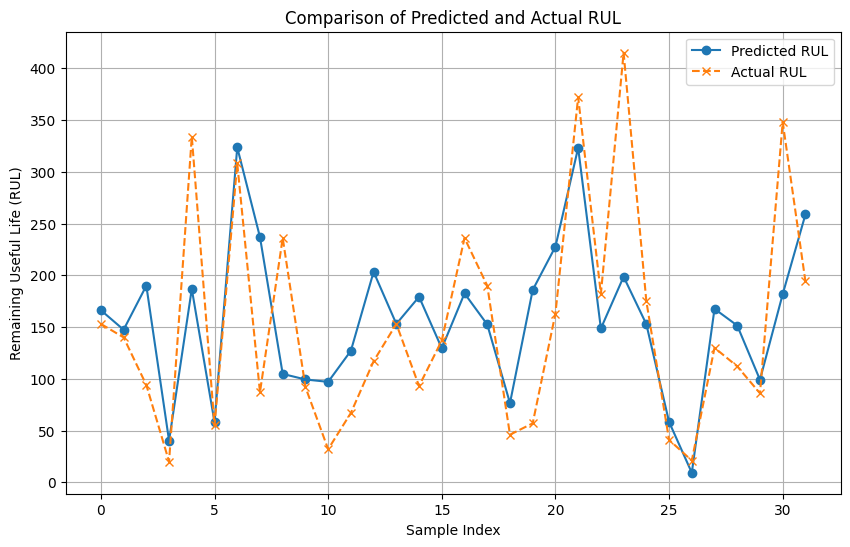

loss=0.02350321039557457
actual rul = [166.24396  147.39775  189.9553    40.171833 186.75992   58.200954
 323.6354   236.86644  104.71568   99.34843   97.03728  127.0482
 203.31865  153.01825  179.22835  129.46974  182.49005  152.4683
  76.48274  185.80103  227.66676  323.13647  148.59268  198.59827
 152.76755   58.35056    9.261859 167.58894  151.43661   99.07024
 181.76094  258.7216  ]
actual target=[153.       140.        94.        20.       334.        55.
 308.        87.       236.        92.        32.        67.
 117.       153.        93.       137.       236.       190.
  46.        57.       163.       372.       182.       415.
 175.        41.        20.999998 130.       112.        86.
 348.       194.      ]


In [20]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[1], return_actual_rul=True, show_fig=True)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

In [21]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[2], return_actual_rul=True, show_fig=False)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

loss=0.017438964918255806
actual rul = [169.09438  168.84741  152.33847  184.49449   18.602716  28.125143
  96.05958  213.58806  121.86057  124.55829  117.18      37.016174
 105.81987  219.2129    51.4169   106.74985  170.23575   87.90484
 163.17412  207.85243  193.78671  184.85464   86.704926   5.149166
  37.761147  12.379563 139.20726  252.57115  188.38348   26.199713
  83.807144 117.15625 ]
actual target=[160. 119. 321. 426.  18.   9. 108. 229. 137.  79. 112.  44. 159. 215.
  44. 167.  78.  79.  79. 265. 154.  72.  76.   0.  27.   2. 114. 169.
 266.  10.  82. 199.]


## Step 2: Federated Learning with Flower

#### Update model parameters

In [22]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)


def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

#### Define the Flower ClientApp

In [23]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train(model=self.model, client_loader_train=self.trainloader, client_loader_validation=self.valloader, epochs=1)
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [24]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1).to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#### Define the Flower ServerApp

In [25]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [26]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

#### Run the training

In [27]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
# if DEVICE.type == "cuda":
#     backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [28]:
# Run simulation
NUM_CLIENTS = 10
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=6487) 2024-12-01 14:29:26.823513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6487) 2024-12-01 14:29:26.878025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6487) 2024-12-01 14:29:26.893210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=6488) 2024-12-01 14:29:27.188747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable 

(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.09152825407006523, Val Loss = 0.028747867327183485
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.08653381189162081, Val Loss = 0.03071289782279304
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.08540856018662453, Val Loss = 0.029681073036044836
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.0793190870095383, Val Loss = 0.03168304849948202
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.08616264489564028, Val Loss = 0.030265295079776218
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.08863377909768712, Val Loss = 0.027497066717062677
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.08619627884843133, Val Loss = 0.027908374621931995
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.0896201647140763, Val Loss = 0.024402952819530453
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.08502434038303115, Val Loss = 0.025138779942478453


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.08386659107424996, Val Loss = 0.02985522217516388


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.04628810435533524, Val Loss = 0.022242742124944925
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.04530118741095066, Val Loss = 0.023540724201926162
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.046593985469503836, Val Loss = 0.02767060391072716
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.05124219896441156, Val Loss = 0.021393997062529837
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.04403081410987811, Val Loss = 0.025929837753730162
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.046886151080781764, Val Loss = 0.019339899931635176
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.04582011137496341, Val Loss = 0.023635341253663813
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.04192455844445662, Val Loss = 0.021593842056712935
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.04746407436376268, Val Loss = 0.030681630729564598


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.04774554365060546, Val Loss = 0.02594311854669026


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.03438845869492401, Val Loss = 0.016797077908579792
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.034193644181571226, Val Loss = 0.01736408601781087
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.03687313077124682, Val Loss = 0.01933782600930759
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.03474801391024481, Val Loss = 0.028938093754862036
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.03111314946277575, Val Loss = 0.015404677617230586
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.03339466205374761, Val Loss = 0.022808591169970378
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.03467521201819181, Val Loss = 0.021192031114229133
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.03329852912575006, Val Loss = 0.014283830299973488
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0367543490095572, Val Loss = 0.02404378288026367


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.03747261759232391, Val Loss = 0.018195840530097485


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.028823380917310716, Val Loss = 0.018505200078444823
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02788471095263958, Val Loss = 0.016259829081328853
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.028372886235063725, Val Loss = 0.01688626248921667
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.029253767989575862, Val Loss = 0.017397115539227213
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.026492563770575957, Val Loss = 0.019993075036576817
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02867540718818253, Val Loss = 0.01787614177114197
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.02968782652169466, Val Loss = 0.015414728417194315
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.0294405228712342, Val Loss = 0.017142350053680793
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.029908789541910997, Val Loss = 0.016012292388560518


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.028114226528189398, Val Loss = 0.01485259085893631


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.026988954351029614, Val Loss = 0.014818834440250481
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.025983213565566324, Val Loss = 0.014095898385026626
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02509639954025095, Val Loss = 0.014707909298262425
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.02369798276234757, Val Loss = 0.014118424117831247
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02485757614062591, Val Loss = 0.011346296606851476
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.02703363812443885, Val Loss = 0.014860551006027631
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.024849645607173444, Val Loss = 0.014456111255900137
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.026715839383277026, Val Loss = 0.026383126952818463
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.026033799214796587, Val Loss = 0.013664686786276954


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.023226389271969145, Val Loss = 0.014193890150636435


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.024378693357787348, Val Loss = 0.015589553397148848
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02332550043409521, Val Loss = 0.013191265353400792
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.022965074093504387, Val Loss = 0.01628611745711948
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.023212499882687223, Val Loss = 0.01412792836448976
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.022946334664117208, Val Loss = 0.01615143085031637
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02292850161479278, Val Loss = 0.013639957045337983
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.023140156810933895, Val Loss = 0.015029393336070436
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.023620440336790952, Val Loss = 0.015345259835677487
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02312210883775895, Val Loss = 0.01290142472966441


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.021922823194075715, Val Loss = 0.013206070089446647


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.022175392796370118, Val Loss = 0.020446193337972676
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.021808826381509955, Val Loss = 0.0141009754235191
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.019348890977826987, Val Loss = 0.011113094631582499
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02011897221884944, Val Loss = 0.01536346526284303
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0218447657302022, Val Loss = 0.013961480498047811
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02080334343693473, Val Loss = 0.013481326600802796
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.021162783269855108, Val Loss = 0.0131988142883139
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.021911393309181387, Val Loss = 0.01314679576483156
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.022818841912191024, Val Loss = 0.015292397367634944


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02178547161377289, Val Loss = 0.015133836373154606


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.020762520368126307, Val Loss = 0.01393502697880779
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.020587191527540034, Val Loss = 0.013016864391309875
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.019619715594771235, Val Loss = 0.013599316589534283
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.019442150005224076, Val Loss = 0.013969962019473314
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01983704286712137, Val Loss = 0.013984683435410261
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.019723403775556522, Val Loss = 0.014449399962489094
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.02046168934215199, Val Loss = 0.016478598783058778
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.020026828788898207, Val Loss = 0.013113171660474368
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.02060107712379911, Val Loss = 0.014096688978107912


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02009156879714944, Val Loss = 0.014437883460362042


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01850625147873705, Val Loss = 0.012281713342028005
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017819945548068393, Val Loss = 0.013013844511338643
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01875162228772586, Val Loss = 0.014578486726220165
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.018492502482099965, Val Loss = 0.014948842514838492
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.018241135792976076, Val Loss = 0.013650717080703803
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.018640787357633765, Val Loss = 0.011779857233964972
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.018484743870794774, Val Loss = 0.010592181202290314
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.02162350534715436, Val Loss = 0.014042086134265577


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.02038569577376951, Val Loss = 0.014503786041002189


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.019768228754401207, Val Loss = 0.013474948005750775


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.019294966418634762, Val Loss = 0.013241163587995939
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.018511139491403646, Val Loss = 0.012706030043773353
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017405339584431866, Val Loss = 0.012955157618437494
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017957310895012183, Val Loss = 0.014605943113565445
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017478091100400144, Val Loss = 0.0135375842052911
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.018359228613024407, Val Loss = 0.012996368609102709
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.019263360480015927, Val Loss = 0.01547007601974266
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01726963765580546, Val Loss = 0.011896765657833644
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.018287718753245745, Val Loss = 0.010358133186985339


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017209423595870084, Val Loss = 0.013144179247319698


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.018216384066776795, Val Loss = 0.013390741577105863
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.018118241607126863, Val Loss = 0.012551398581958242
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017005159646611322, Val Loss = 0.01243247464299202
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.018439947280355477, Val Loss = 0.013955646094733052
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017032942150465465, Val Loss = 0.01326684168140803
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01714159861545671, Val Loss = 0.010714059030371053
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.018060221218250013, Val Loss = 0.013900602968143565
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017829370710321448, Val Loss = 0.01300065073051623
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017225107254291123, Val Loss = 0.012378918605723552


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01603356489742344, Val Loss = 0.0131714050325432


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016508386639708824, Val Loss = 0.014154053891875915
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.016019500876692207, Val Loss = 0.012857194890135102
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.018369331320917063, Val Loss = 0.019361424459410564
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017150533995167777, Val Loss = 0.012748773974765624
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01750738602978262, Val Loss = 0.016386274514453753
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01671475718136538, Val Loss = 0.011585161056635635
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017934719456190414, Val Loss = 0.012349715456366539
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017176344110207124, Val Loss = 0.014004387127767717
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017484917559406975, Val Loss = 0.011788194633222051


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017773818131536244, Val Loss = 0.014918555039912462


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01704780547456308, Val Loss = 0.014418408840096422
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017384707487442277, Val Loss = 0.012990353429423911
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01672370382161303, Val Loss = 0.011862336890771985
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01612819858234037, Val Loss = 0.012465330339702112
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.016828876428983428, Val Loss = 0.012627498479560018
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016591424638913436, Val Loss = 0.013012977383498634
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01676844134926796, Val Loss = 0.011501051119661756
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01632162251255729, Val Loss = 0.012576810017760311
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017088954320008103, Val Loss = 0.014714131198291267


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01690007560801777, Val Loss = 0.01306618972947555


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01683636394075372, Val Loss = 0.013020466647243925
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01580602301454002, Val Loss = 0.011909614649734326
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016625016758387737, Val Loss = 0.014298149650650365
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01648367815227671, Val Loss = 0.013180026950846826
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01757097916508263, Val Loss = 0.010419371903740935
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015695067401975394, Val Loss = 0.012141251703724265
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015097744136371397, Val Loss = 0.011775625237662877
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01523526647890156, Val Loss = 0.012160353029945068
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016830062612213873, Val Loss = 0.013454288344031997


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014852180154147474, Val Loss = 0.015121290726321084


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.017302162471142683, Val Loss = 0.013412565824442677
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015636935093524783, Val Loss = 0.01281212137213775
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015787939354777337, Val Loss = 0.013690027607870954
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.016225043176250023, Val Loss = 0.0140050017008824
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015292116779495369, Val Loss = 0.012398597817601902
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015587391568855805, Val Loss = 0.013464245346507855
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015012005648829721, Val Loss = 0.012206718658230134
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01632871593941342, Val Loss = 0.012364456729431237
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.017256311801346867, Val Loss = 0.013752346060105733


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016667497335848484, Val Loss = 0.0123785635722535


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015743044416674158, Val Loss = 0.011466667322175843
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01641828322105787, Val Loss = 0.01272846625319549
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016130620579827917, Val Loss = 0.013594352041504212
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014371738100255077, Val Loss = 0.012577741839257734
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01571456410668113, Val Loss = 0.013494772670258368
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014859457517212087, Val Loss = 0.011564400346417512
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015264381265098399, Val Loss = 0.013150859823716539
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01523642341860316, Val Loss = 0.009864706146929945
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015744338277727365, Val Loss = 0.012655407190322876


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01493160231038928, Val Loss = 0.013431768365470427


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01604085983708501, Val Loss = 0.01295619727378445
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01602827047251842, Val Loss = 0.013508147892675229
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014775330048393119, Val Loss = 0.013573105214163661
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014603385667909275, Val Loss = 0.01237857383343258
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01501474329693751, Val Loss = 0.009802533679508738
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015562452308156274, Val Loss = 0.013896738045981951
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014835348327390172, Val Loss = 0.012151583230921201
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01572869203307412, Val Loss = 0.01390955610466855


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01635108898309144, Val Loss = 0.013157092932877796
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014992588623003527, Val Loss = 0.013959052839449473


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014444037111984057, Val Loss = 0.015601363232625383
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.016354903993620114, Val Loss = 0.013302750386563795
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01510590777986429, Val Loss = 0.009831041363733155
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014465734735131264, Val Loss = 0.01198350708000362
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015224972892213952, Val Loss = 0.013037358377394932
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014570188962600449, Val Loss = 0.011420596623793244
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015649900636212393, Val Loss = 0.01096575750437166
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014978730593892662, Val Loss = 0.014373881143650838
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.016246995736252177, Val Loss = 0.013320865874577845


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015096972730349411, Val Loss = 0.014297044636415583


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01551070689139041, Val Loss = 0.01251802425498941
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01640071573413231, Val Loss = 0.011213094494970781
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01658702799203721, Val Loss = 0.013354330722774779
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014813986361365427, Val Loss = 0.009972129283206803
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014732170342044397, Val Loss = 0.01238641854641693
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015000822691416199, Val Loss = 0.014337546591247832
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014136737855997953, Val Loss = 0.012682939513719507
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015682047368450597, Val Loss = 0.013138290095542158
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013919697676531293, Val Loss = 0.012308670407427209


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014294154357842424, Val Loss = 0.011393800643937928


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014092981815338135, Val Loss = 0.012966083728575281
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014931391628289764, Val Loss = 0.012828541553712316
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014377409473738887, Val Loss = 0.013248440975855504
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014284153951501304, Val Loss = 0.012565862786556994
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.0146411708725447, Val Loss = 0.009943518288699644
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014448767985132607, Val Loss = 0.012463388315934156
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014383940762755546, Val Loss = 0.01121220288665167
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014671241830695759, Val Loss = 0.013768868088456137
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015618233154104514, Val Loss = 0.01328257581086031


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015089213323186744, Val Loss = 0.010982177685946226


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01525605042803694, Val Loss = 0.012328393923650895
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014716577038846233, Val Loss = 0.01236325509047934
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014528607644818045, Val Loss = 0.01370698808958488
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014410247111862355, Val Loss = 0.010177768001865064
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014093647854910655, Val Loss = 0.014544382558337279
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01483623574233868, Val Loss = 0.011422114779374428
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014400667366995053, Val Loss = 0.011274533213249274
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014495850159701977, Val Loss = 0.012362711697018572
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01593645882200111, Val Loss = 0.013116085070318409


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013600144628435373, Val Loss = 0.011335892503016762


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014751658656380394, Val Loss = 0.015527377902929271
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014374429292299531, Val Loss = 0.010892879982878054
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01590469822456891, Val Loss = 0.01332866440394095
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014862863236868923, Val Loss = 0.014038779107587678
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014275609219277447, Val Loss = 0.009727178307782327
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014711061577227983, Val Loss = 0.013489993721512812
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013876105006784201, Val Loss = 0.011739850576434816
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014148297931321642, Val Loss = 0.011249588636149253
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013446335875513879, Val Loss = 0.011237296342317547


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013716532416980376, Val Loss = 0.013624474938426698


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014575441122393716, Val Loss = 0.01235334827963795
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015176467758349396, Val Loss = 0.013476537041632193
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014053344828161327, Val Loss = 0.012559157064450639
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013831533957272768, Val Loss = 0.01159804786688515
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013704068366099487, Val Loss = 0.012169137530561005
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014129250030964612, Val Loss = 0.011092068095292364
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014620158677412705, Val Loss = 0.013216273659574134
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014017092741348526, Val Loss = 0.012291440939796823
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014685191044753248, Val Loss = 0.009662709564768843


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014146411478180777, Val Loss = 0.012441887919391905


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015629577094858342, Val Loss = 0.013399532064795494
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012974134180694818, Val Loss = 0.011263108080519097
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014631172938441689, Val Loss = 0.012256600860772389
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01356579450551759, Val Loss = 0.009784509926768286
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01394953095269474, Val Loss = 0.012298829421134931
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013961840404028243, Val Loss = 0.011692269638712918
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01557157982818105, Val Loss = 0.01437417627312243
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014777635207230395, Val Loss = 0.012612305648092712
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013725589842281559, Val Loss = 0.013859357019620282


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01405677350915291, Val Loss = 0.011439415094043528


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01453850989822637, Val Loss = 0.012612150715930122
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015049101513895121, Val Loss = 0.014070348681083747
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013130201204595241, Val Loss = 0.01110406665663634
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0136647798798301, Val Loss = 0.009604719833337836
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013272072036157954, Val Loss = 0.016100329480000904
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013421276728199287, Val Loss = 0.01132638389909906
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014282077474688942, Val Loss = 0.011483358518619622


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014268780939958313, Val Loss = 0.012880068904321109
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013429091803052209, Val Loss = 0.012157734749572617
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013955566291273995, Val Loss = 0.011842334576483284


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014580001656643369, Val Loss = 0.013213991254035915
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014544837693260475, Val Loss = 0.012329545770106571
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013559315573762764, Val Loss = 0.01263555239087769
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013720587234605442, Val Loss = 0.009743899522748376
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012692318289456042, Val Loss = 0.011766768892162613
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013518269478597425, Val Loss = 0.0115023129619658
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013864097947424108, Val Loss = 0.011264106458319085
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014148879356004975, Val Loss = 0.012611955504066177
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013304043815217236, Val Loss = 0.012374901811459236


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01434541658752344, Val Loss = 0.012160989721970899


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012501336998221549, Val Loss = 0.010787484868030463
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013945506724782966, Val Loss = 0.012296916850443398
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013809972434219988, Val Loss = 0.012404065479391388
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013372947478836232, Val Loss = 0.012685492634773254
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013497823586856778, Val Loss = 0.012188046971069915
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013580080316486684, Val Loss = 0.012320174702576228
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013241574456068602, Val Loss = 0.012138575947444354
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015048305004496465, Val Loss = 0.012797667678179485
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013837040613659403, Val Loss = 0.01071728820846017


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013802015654404054, Val Loss = 0.009555604242320572


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014497149998152797, Val Loss = 0.01318278895424945
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014241121658547358, Val Loss = 0.011036841148909713
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013179843381724574, Val Loss = 0.010902628967804568
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013543759354136207, Val Loss = 0.015238740514697773
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013759747232225809, Val Loss = 0.012389180084158267
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013795414829457347, Val Loss = 0.009906521033761757
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014199925705113194, Val Loss = 0.012870191529925381
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013165323224596001, Val Loss = 0.01181501755490899
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012973720800470222, Val Loss = 0.011088271625339985


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013398925096473911, Val Loss = 0.011414577818608709


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013902413023805077, Val Loss = 0.014939637987741403
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014105738970366391, Val Loss = 0.011317760716857654
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012951854971999471, Val Loss = 0.014136607958269971
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013587079696695913, Val Loss = 0.009851794124447874
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013388894583013925, Val Loss = 0.011146641868565763
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013349696003239262, Val Loss = 0.011479711226586784
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013338768829337575, Val Loss = 0.014389358660472291
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01416315764866092, Val Loss = 0.012621191064161914


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012499992481686852, Val Loss = 0.010771274666434951
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.015479228400032628, Val Loss = 0.013932397589087486


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013936294962398031, Val Loss = 0.012402866434838091
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013565079842440106, Val Loss = 0.010765153282721127
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013341523647647012, Val Loss = 0.012224023197112339
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01298547609793869, Val Loss = 0.010837683387632881
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013638874312693422, Val Loss = 0.009659247273313147
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012555937748402357, Val Loss = 0.012001719691657595
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013461327671327374, Val Loss = 0.011612724579338516
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013300252942876383, Val Loss = 0.012773176522127219
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013193159220232205, Val Loss = 0.012492502773446696


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014363668977536938, Val Loss = 0.012962789540844304


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014152999442409385, Val Loss = 0.013687698104019676
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013881430410864678, Val Loss = 0.01078084992643978
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013880968669598754, Val Loss = 0.012516399047204427
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013409294425086541, Val Loss = 0.011311079342184322
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013178052846342325, Val Loss = 0.012045631384743112
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012858414878560738, Val Loss = 0.010865033903558339
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012801003760912201, Val Loss = 0.01302151069311159
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0127069104462862, Val Loss = 0.011594961264303752
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012806499275294217, Val Loss = 0.012536034187568086


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014542404274371538, Val Loss = 0.014339184721133538


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014135501372881911, Val Loss = 0.012988060712814331
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01452941463582895, Val Loss = 0.013376548487160887
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012726288127966903, Val Loss = 0.012642787303775549
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012918554204092785, Val Loss = 0.012315912804167186
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012277006353674964, Val Loss = 0.011872234105664705
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013118653354996984, Val Loss = 0.011562146645571505
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013071921527047049, Val Loss = 0.011112511257774063
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013405007471076466, Val Loss = 0.011808401672169566
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013364445731382478, Val Loss = 0.00958237876849515


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012564972398633306, Val Loss = 0.011049406137317419


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013598771816627546, Val Loss = 0.012308743250157152
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014539506904442202, Val Loss = 0.014320481202698179
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01246755812317133, Val Loss = 0.011385352949478797
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012986891674385829, Val Loss = 0.01058381177218897
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013230796649374744, Val Loss = 0.011487593142581838
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01274344895712354, Val Loss = 0.014028239995241165
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012600809886035595, Val Loss = 0.012145876585106765
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012016663357446139, Val Loss = 0.011796325212344527
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013646728875623508, Val Loss = 0.010549012305481094


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013750666760924188, Val Loss = 0.012375876573579652


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013707026153464209, Val Loss = 0.012069153366610408
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01386215023865754, Val Loss = 0.010928658369396414
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013085797005756334, Val Loss = 0.012337351683527231
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013042513035576452, Val Loss = 0.012436602430950319
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013667909682474354, Val Loss = 0.010100361525214143
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012893249335783449, Val Loss = 0.011981765939188855
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013772004910490729, Val Loss = 0.013218705109985811
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012238618303936992, Val Loss = 0.011230238513754947
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013115478806536306, Val Loss = 0.010655793461150356


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011929891952736811, Val Loss = 0.012214713164472155


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01340402341871099, Val Loss = 0.012095161647136723
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013624571153724735, Val Loss = 0.010550751783219832
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014113656516102227, Val Loss = 0.013820703507268004
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013291905464773828, Val Loss = 0.012639987681593214
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011794766233387318, Val Loss = 0.01225640781090728
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01327585123310035, Val Loss = 0.011841265917090433
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012858540878038515, Val Loss = 0.010768395715526171
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013175056798552924, Val Loss = 0.012100192934407719
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01224147572436116, Val Loss = 0.011309441977313586


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012988111855123531, Val Loss = 0.01129331486299634


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01377656144851988, Val Loss = 0.012283768604642578
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012455634586513043, Val Loss = 0.012561024964920111
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012686020902103998, Val Loss = 0.01058463885315827
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012341331673616713, Val Loss = 0.012434703564005238
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013007922876964916, Val Loss = 0.011760869562359793
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012778742171146653, Val Loss = 0.011856725971613611
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012891180195253003, Val Loss = 0.011758786925513829
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013142695235596462, Val Loss = 0.011961254856682249
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01419527367265387, Val Loss = 0.014180561926748072


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013005285904827442, Val Loss = 0.010980843932234816


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.015012529517777942, Val Loss = 0.013426651479676366
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013013209182430397, Val Loss = 0.010856320374711816
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012073091002689166, Val Loss = 0.011390977539122105
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0130969967269762, Val Loss = 0.012360728811472654
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012685589754784649, Val Loss = 0.011949910299985536
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012814689948308196, Val Loss = 0.009368577739223838
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012834060285240412, Val Loss = 0.01185055575998766
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012738689949566668, Val Loss = 0.011220896117655295


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01329250750131905, Val Loss = 0.012443566129409842


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012457785840061578, Val Loss = 0.011649767568867122


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012709511422806165, Val Loss = 0.0115717020817101
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.014098975223235109, Val Loss = 0.013458933248849851
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012760315149683845, Val Loss = 0.012630962251153375
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01369769809428941, Val Loss = 0.012180468799280269
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013014110567217524, Val Loss = 0.011121932616723436
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01242563660171899, Val Loss = 0.012426012993923255
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01270624442364682, Val Loss = 0.011392786400392652
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012632303858514536, Val Loss = 0.01113954622165433
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013303735454312779, Val Loss = 0.010553196438455157


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012854595406150277, Val Loss = 0.012322990755949701


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014112225776030258, Val Loss = 0.012753884507609265
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01322471628134901, Val Loss = 0.012619310324745519
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01321206974204291, Val Loss = 0.012122954674331205
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012623978211459788, Val Loss = 0.012140332222250956
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012608523878522895, Val Loss = 0.011812706245109439
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012899420012465933, Val Loss = 0.01134934342865433
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012084275331686843, Val Loss = 0.011658578512391873
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013318469379605218, Val Loss = 0.01069213732677911
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013319811944595791, Val Loss = 0.011026447406038642


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012640778567980637, Val Loss = 0.010948334388168795


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013145753698931499, Val Loss = 0.01205874081434948
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011890796461904591, Val Loss = 0.011028641369193792
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012817316413433715, Val Loss = 0.009238996276898044
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012353129286996343, Val Loss = 0.011504115303978324
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01324909550391815, Val Loss = 0.011207692624468888
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012521616665815765, Val Loss = 0.010623073970366801
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01336409833112901, Val Loss = 0.010529171342828445
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013199397053738886, Val Loss = 0.012132035169218267
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.014363542266867377, Val Loss = 0.012945986768629934


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012183537808331577, Val Loss = 0.011952718453747886


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013329509552568198, Val Loss = 0.011677979924050825
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013478954237970438, Val Loss = 0.012044847843104176
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012275373317639936, Val Loss = 0.010622745146974921
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013332614785229619, Val Loss = 0.011984826431476645
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012669268555261872, Val Loss = 0.011774028185755014
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012782016921449792, Val Loss = 0.009740804222279362
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013918746338987893, Val Loss = 0.012931727371843798
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011663528125394474, Val Loss = 0.012221358250826597
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013590958418155259, Val Loss = 0.012015843697424446


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01272833128036423, Val Loss = 0.01045419618354312


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012614416009323164, Val Loss = 0.010894455747412784
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013245395782657645, Val Loss = 0.012473957546587502
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01341096397319978, Val Loss = 0.012747101186375533
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012739668913524259, Val Loss = 0.00959326682745346
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012178690824657678, Val Loss = 0.012273415424195784
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013140965092249893, Val Loss = 0.011047772797090667
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013743708189576865, Val Loss = 0.013291783930201615
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012368990463966672, Val Loss = 0.011828738331262554


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012528964250602506, Val Loss = 0.012117631567109908
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011988619587976824, Val Loss = 0.012731823604553938


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013409696515141564, Val Loss = 0.012231089706931795
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013971967893567952, Val Loss = 0.012832107654373561
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012412791030312125, Val Loss = 0.01166162353807262
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.0119130512106825, Val Loss = 0.010901888267004065
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011524173693562095, Val Loss = 0.01195573530692075
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012236500141972846, Val Loss = 0.011579830266003097
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01286453784189441, Val Loss = 0.012751714925148658
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012905133210799911, Val Loss = 0.010151902246954185
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012359543576497923, Val Loss = 0.011936797095196587


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012852369629862633, Val Loss = 0.010542504921821612


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01324206641451879, Val Loss = 0.011425082738112127
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013737718735567547, Val Loss = 0.013591033672647817
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012002638198265974, Val Loss = 0.010788442367421729
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012664903793483973, Val Loss = 0.011990094657189079
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012455880354073915, Val Loss = 0.009471297796283449
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012283431679349054, Val Loss = 0.012036103888281755
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011963484563272108, Val Loss = 0.01194554301244872
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01264615848406472, Val Loss = 0.010968230731253113
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013384048073467884, Val Loss = 0.011900153110868164


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013046083717860958, Val Loss = 0.012923100796927298


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013090664220296524, Val Loss = 0.013631031848490238
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013180913581428203, Val Loss = 0.011594088282436132
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012100029448893938, Val Loss = 0.011063218781990665
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013528289764442227, Val Loss = 0.012811381103737014
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013196052306077698, Val Loss = 0.012333740779597844
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.0127787756818262, Val Loss = 0.012200323432417852
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01256995381025428, Val Loss = 0.012408568523824215
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012268844060599804, Val Loss = 0.009502552449703217


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01214871033179489, Val Loss = 0.012333825796044298
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012297373866154388, Val Loss = 0.011816259506823761


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013750874318859794, Val Loss = 0.014166031099323715
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013064993494613604, Val Loss = 0.011953718295054776
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012447188299318606, Val Loss = 0.009512104260336076
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011890058126300573, Val Loss = 0.01224305627069303
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012870993075722998, Val Loss = 0.011153791765017169
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012567561593922702, Val Loss = 0.01078724448702165
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01187135519629175, Val Loss = 0.010440184136054345
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01264433025975119, Val Loss = 0.011812199771936451
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013270456225357273, Val Loss = 0.01032562623731792


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012894875107502396, Val Loss = 0.012607059508029903


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013585309260948138, Val Loss = 0.012845631456002593
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012735070796175436, Val Loss = 0.012048927069242512
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012644384064796297, Val Loss = 0.01215833518654108
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012369289600544356, Val Loss = 0.014041314566774028
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011836209266700528, Val Loss = 0.011657283391936548
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012641437478702177, Val Loss = 0.011528246237763337
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012680832711471753, Val Loss = 0.010199784351113652
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0126662179319696, Val Loss = 0.011885109523843442
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011979579950936816, Val Loss = 0.010725156204508883


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01248113743283532, Val Loss = 0.010481701897723334


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013675992140038448, Val Loss = 0.013848340937069483
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012860585444352843, Val Loss = 0.012384595183123435
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012599337278780612, Val Loss = 0.01172683311493269
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012587654455141588, Val Loss = 0.01010272216184863
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.01162199429659681, Val Loss = 0.012111438039158071
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012121862740340559, Val Loss = 0.01161943153212113
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012946272963149982, Val Loss = 0.010682030713983945
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.01252039299261841, Val Loss = 0.010717347097982253
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011749740740792318, Val Loss = 0.011476370871865324


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.013205769209360535, Val Loss = 0.013412938785872288


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012758450946685942, Val Loss = 0.013173585890659265
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012885020190680569, Val Loss = 0.010432518103958241
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011815988196229393, Val Loss = 0.010965544564117278
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012882758380675858, Val Loss = 0.012543247014816319
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012248948584734038, Val Loss = 0.009507686764534031
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012038327897475524, Val Loss = 0.011715997742222888
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.0138904177329757, Val Loss = 0.014473230511482273
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.011403118463402445, Val Loss = 0.011903106501059873
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012452035431157459, Val Loss = 0.011759106535464525


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012176597888835452, Val Loss = 0.012052860576659441


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011883315054530446, Val Loss = 0.01077432484765138
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012713807084682312, Val Loss = 0.011742387432605028
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012413087038492615, Val Loss = 0.011707901289420468
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012753426562994719, Val Loss = 0.009891981791172708
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012355454020540823, Val Loss = 0.011112362778346454
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.011628478041596033, Val Loss = 0.012366239563561976
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012521042005920953, Val Loss = 0.010271918560777391
(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.013511957465247675, Val Loss = 0.01290804852864572
(ClientAppActor pid=6488) Epoch 1: Train Loss = 0.012772114337845282, Val Loss = 0.012019082105585508


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=6487) Epoch 1: Train Loss = 0.012682390577075157, Val Loss = 0.013437598810664244


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 10574.23s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02740146280931575
INFO :      		round 2: 0.02386108876339027
INFO :      		round 3: 0.018441015787954842
INFO :      		round 4: 0.016619573014655283
INFO :      		round 5: 0.014113292151263782
INFO :      		round 6: 0.014050930000043342
INFO :      		round 7: 0.013772607288722481
INFO :      		round 8: 0.013331366150772997
INFO :      		round 9: 0.01267406183427998
INFO :      		round 10: 0.012159303489274213
INFO :      		round 11: 0.013250115793198347
INFO :      		round 12: 0.01273172312150044
INFO :      		round 13: 0.012713138865573065
INFO :      		round 14: 0.012642235162534885
INFO :      		round 15: 0.012353095192728298
INFO :      		round 16: 0.012021969591400453
INFO :      		round 17: 0.012078945431858302
INFO :      		round 18: 0.011656062817201019
INFO :    

#### Where's the accuracy?

In [29]:
# def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
#     # Multiply accuracy of each client by number of examples used
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]

#     # Aggregate and return custom metric (weighted average)
#     return {"accuracy": sum(accuracies) / sum(examples)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# def server_fn(context: Context) -> ServerAppComponents:
#     """Construct components that set the ServerApp behaviour.

#     You can use settings in `context.run_config` to parameterize the
#     construction of all elements (e.g the strategy or the number of rounds)
#     wrapped in the returned ServerAppComponents object.
#     """

#     # Create FedAvg strategy
#     strategy = FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     )

#     # Configure the server for 5 rounds of training
#     config = ServerConfig(num_rounds=5)

#     return ServerAppComponents(strategy=strategy, config=config)


# # Create a new server instance with the updated FedAvg strategy
# server = ServerApp(server_fn=server_fn)

# # Run simulation
# run_simulation(
#     server_app=server,
#     client_app=client,
#     num_supernodes=NUM_CLIENTS,
#     backend_config=backend_config,
# )